In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-zoomcamp-2024-competition/actual_matrix.csv
/kaggle/input/ml-zoomcamp-2024-competition/discounts_history.csv
/kaggle/input/ml-zoomcamp-2024-competition/price_history.csv
/kaggle/input/ml-zoomcamp-2024-competition/sample_submission.csv
/kaggle/input/ml-zoomcamp-2024-competition/catalog.csv
/kaggle/input/ml-zoomcamp-2024-competition/markdowns.csv
/kaggle/input/ml-zoomcamp-2024-competition/online.csv
/kaggle/input/ml-zoomcamp-2024-competition/sales.csv
/kaggle/input/ml-zoomcamp-2024-competition/stores.csv
/kaggle/input/ml-zoomcamp-2024-competition/test.csv


In [2]:
sample_submission = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/sample_submission.csv")

In [3]:
sample_submission.head()

,row_id,quantity
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [4]:
import xgboost as xgba
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [5]:
sales = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/sales.csv")
online = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/online.csv")
markdown = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/markdowns.csv")
price_history = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/price_history.csv")
discount_history = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/discounts_history.csv")
actual_matrix = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/actual_matrix.csv")
catalog = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/catalog.csv")
stores = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/stores.csv")

In [1]:
# Merge sales and online data with suffixes to differentiate offline and online columns
# sales_online_merged = pd.merge(sales, online, on=["date", "item_id", "store_id"], suffixes=('_offline', '_online'))

sales_online_merged = pd.merge(sales, markdown, on=["date", "item_id", "store_id"])

# Merge with markdowns using 'left' join to keep all sales data
# sales_online_merged = pd.merge(sales_online_merge, markdown, on=["date", "item_id", "store_id"], how="left")

# Merge with price_history using 'left' join to keep all previous data
sales_online_merged = pd.merge(sales_online_merged, price_history, on=["date", "item_id", "store_id"], how="left")

# Merge with discount_history using 'left' join to keep all previous data
# sales_online_merged = pd.merge(sales_online_merged, discount_history, on=["date", "item_id", "store_id"], how="left")

# Merge with actual_matrix to add product availability data
# sales_online_merged = pd.merge(sales_online_merged, actual_matrix, on=["item_id", "store_id"], how="left", suffixes=('_sales', '_matrix'))

# Merge with catalog to add product details
# sales_online_merged = pd.merge(sales_online_merged, catalog, on="item_id", how="left")

# Final merge with stores to add store-specific information and add suffix for store columns
final_merged = pd.merge(sales_online_merged, stores, on="store_id", how="left", suffixes=('', '_store'))

NameError: name 'pd' is not defined

In [7]:
# Final merge with stores to add store-specific information and add suffix for store columns
final_merged = pd.merge(sales_online_merged, stores, on="store_id", how="left", suffixes=('', '_store'))

In [8]:
final_merged.isnull().sum() / final_merged.shape[0]

Unnamed: 0_x        0.000000
date                0.000000
item_id             0.000000
quantity_x          0.000000
price_base          0.000000
sum_total           0.000000
store_id            0.000000
Unnamed: 0_y        0.000000
normal_price        0.000000
price_x             0.000000
quantity_y          0.000000
Unnamed: 0          0.977859
price_y             0.977859
code                0.977859
Unnamed: 0_store    0.000000
division            0.000000
format              0.000000
city                0.000000
area                0.000000
dtype: float64

In [9]:
final_merged.shape

(9033, 19)

## drop coulmns with > 0.5% of missing data and irrelevant dataset

In [10]:
final_merged.columns

Index(['Unnamed: 0_x', 'date', 'item_id', 'quantity_x', 'price_base',
       'sum_total', 'store_id', 'Unnamed: 0_y', 'normal_price', 'price_x',
       'quantity_y', 'Unnamed: 0', 'price_y', 'code', 'Unnamed: 0_store',
       'division', 'format', 'city', 'area'],
      dtype='object')

In [11]:
# first remove the unnamed coulmn
# final_merged = final_merged.drop(columns=["Unnamed: 0_x", "Unnamed: 0", "Unnamed: 0_matrix", 'Unnamed: 0_offline','Unnamed: 0_online', 'Unnamed: 0_y', 'Unnamed: 0_store', 'Unnamed: 0_sales'])
final_merged = final_merged.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y', 'Unnamed: 0', 'Unnamed: 0_store'])

In [12]:
final_merged.columns

Index(['date', 'item_id', 'quantity_x', 'price_base', 'sum_total', 'store_id',
       'normal_price', 'price_x', 'quantity_y', 'price_y', 'code', 'division',
       'format', 'city', 'area'],
      dtype='object')

In [13]:
# drop columns with > 50% missing values
# final_merged = final_merged.drop(columns=['normal_price', 'price_x', 'quantity', 'price_y',
#        'code', 'sale_price_before_promo', 'sale_price_time_promo',
#        'promo_type_code', 'doc_id', 'number_disc_day', "fatness"])

final_merged = final_merged.drop(columns=['price_y', 'code'])

In [14]:
final_merged.isnull().sum() / final_merged.shape[0]

date            0.0
item_id         0.0
quantity_x      0.0
price_base      0.0
sum_total       0.0
store_id        0.0
normal_price    0.0
price_x         0.0
quantity_y      0.0
division        0.0
format          0.0
city            0.0
area            0.0
dtype: float64

In [15]:
final_merged.tail()

,date,item_id,quantity_x,price_base,sum_total,store_id,normal_price,price_x,quantity_y,division,format,city,area
9028,2024-09-26,383eda871fca,9.0,742.53,6682.80,4,789.0,370.8,1.0,Div1,MaxiEuro,City3,1887
9029,2024-09-26,4cf0bb777594,2.0,339.36,678.72,4,569.0,340.2,2.0,Div1,MaxiEuro,City3,1887
9030,2024-09-26,5ec8eafeb7ce,9.0,167.23,1505.05,4,209.0,86.3,3.0,Div1,MaxiEuro,City3,1887
9031,2024-09-26,d60184cf6ca5,5.0,191.04,955.20,4,199.0,119.4,2.0,Div1,MaxiEuro,City3,1887
9032,2024-09-26,07605df7333f,4.0,163.87,655.46,4,199.0,95.6,1.0,Div1,MaxiEuro,City3,1887


## Create the target column

In [16]:
# create a total quantity column which would be the y value
# final_merged["total_quantity"] = final_merged["quantity_offline"] + final_merged["quantity_online"]

### Split the dataset

In [17]:
# final_merged["date_sales"] = pd.to_datetime(final_merged["date_sales"])

final_merged["date"] = pd.to_datetime(final_merged["date"])

# Sort the data by date to ensure proper time order
final_merged = final_merged.sort_values(by="date")

# Calculate the index for 80% of the data
split_index = int(0.8 * len(final_merged))

# Split into training and test sets
train_set = final_merged.iloc[:split_index]
test_set = final_merged.iloc[split_index:]

In [18]:
train_set.duplicated().any(), test_set.duplicated().any()

(True, True)

In [19]:
train_set.shape, test_set.shape

((7226, 13), (1807, 13))

In [20]:
# Remove duplicates from train_set
train_set = train_set.drop_duplicates()

# Remove duplicates from test_set
test_set = test_set.drop_duplicates()

In [21]:
train_set.duplicated().any(), test_set.duplicated().any()

(False, False)

In [22]:
train_set.shape, test_set.shape

((6904, 13), (1806, 13))

## Check the distribution of the target variable

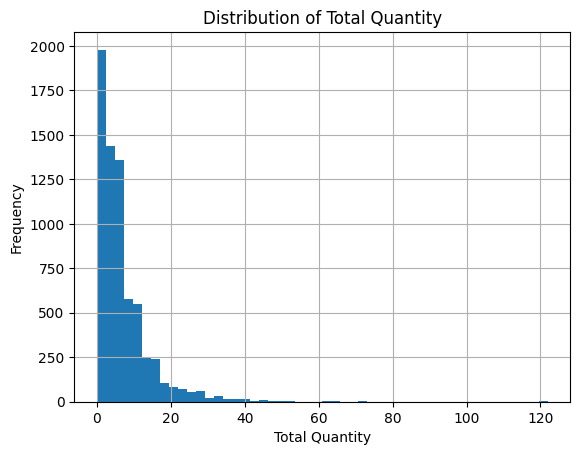

In [23]:
# check the distribution of the target coulmn
train_set["quantity_x"].hist(bins=50)
plt.title('Distribution of Total Quantity')
plt.xlabel('Total Quantity')
plt.ylabel('Frequency')
plt.show()

In [24]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = train_set["quantity_x"].quantile(0.25)
Q3 = train_set["quantity_y"].quantile(0.75)


IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
train_set = train_set[(train_set["quantity_x"] >= lower_bound) & 
                                     (train_set["quantity_x"] <= upper_bound) &
(train_set["quantity_x"] >= 0)]

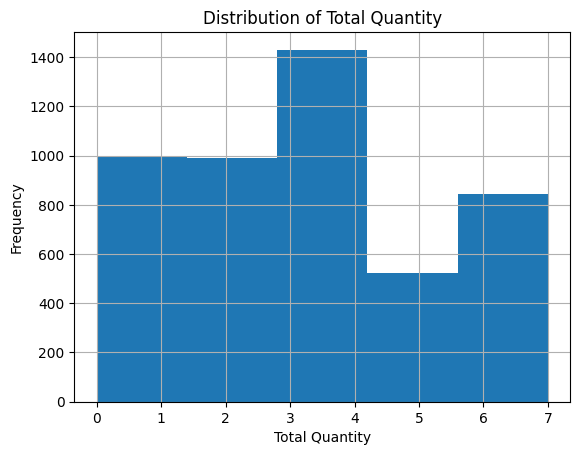

In [25]:
train_set["quantity_x"].hist(bins=5)
plt.title('Distribution of Total Quantity')
plt.xlabel('Total Quantity')
plt.ylabel('Frequency')
plt.show()

In [26]:
# # Apply log transformation (add 1 to avoid log(0) error)
# train_set["total_quantity"] = np.log1p(train_set["total_quantity"])

# # Plot histogram of transformed data (use the filtered dataset)
# train_set["total_quantity"].hist(bins=10)
# plt.title('Distribution of Log-Transformed Total Quantity')
# plt.xlabel('Log(1 + Total Quantity)')
# plt.ylabel('Frequency')
# plt.show()

## EDA 

In [27]:
train_set.describe()

,date,quantity_x,price_base,sum_total,store_id,normal_price,price_x,quantity_y,area
count,4776,4776.000000,4776.000000,4776.000000,4776.000000,4776.000000,4776.000000,4776.000000,4776.000000
mean,2023-07-01 14:04:13.266331648,3.327517,277.256625,901.743275,1.870603,388.475963,233.280442,1.931425,794.065327
min,2022-08-28 00:00:00,0.000000,0.000000,-293.000000,1.000000,21.900000,12.500000,0.115000,210.000000
25%,2023-01-12 18:00:00,2.000000,135.750000,332.000000,1.000000,189.000000,99.900000,1.000000,210.000000
50%,2023-06-20 00:00:00,3.000000,250.000000,661.275000,2.000000,378.000000,235.000000,1.317500,210.000000
75%,2023-12-26 00:00:00,5.000000,394.200000,1165.335000,2.000000,549.000000,341.700000,2.000000,1500.000000
max,2024-05-18 00:00:00,7.000000,1380.500000,6114.700000,4.000000,1990.000000,1380.500000,9.000000,1887.000000
std,NaN,1.913571,169.076379,815.822377,0.837102,219.847010,144.635119,1.253517,689.932614


## There are some outliner in the dataset 
the quantity has negative value, same as price, sum_total

In [28]:
# remove outliner from the dataset
# outliner_column = ["quantity_offline", "price_base_offline","sum_total_offline", "price_base_online", "sum_total_online", "total_quantity"]

outliner_column = ['sum_total']

for col in outliner_column:
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = train_set[col].quantile(0.25)
    Q3 = train_set[col].quantile(0.75)
    
    
    IQR = Q3 - Q1
    
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove outliers
    train_set = train_set[(train_set[col] >= lower_bound) & 
                                         (train_set[col] <= upper_bound) &
    (train_set[col] >= 0)]

In [29]:
train_set.describe()

,date,quantity_x,price_base,sum_total,store_id,normal_price,price_x,quantity_y,area
count,4441,4441.000000,4441.000000,4441.000000,4441.000000,4441.000000,4441.000000,4441.000000,4441.000000
mean,2023-06-24 07:42:22.940779008,3.135379,257.623427,735.051533,1.885161,369.572889,221.044672,1.919046,745.403738
min,2022-08-28 00:00:00,0.115000,0.510000,0.510000,1.000000,21.900000,12.500000,0.115000,210.000000
25%,2023-01-05 00:00:00,2.000000,132.050000,318.200000,1.000000,189.000000,99.000000,1.000000,210.000000
50%,2023-05-30 00:00:00,3.000000,213.820000,604.300000,2.000000,309.000000,193.500000,1.000000,210.000000
75%,2023-12-19 00:00:00,4.000000,365.500000,1023.400000,2.000000,539.000000,336.100000,2.000000,1500.000000
max,2024-05-18 00:00:00,7.000000,1380.500000,2412.100000,4.000000,1990.000000,1380.500000,9.000000,1887.000000
std,NaN,1.824063,156.026196,537.475599,0.804748,213.732066,140.274895,1.247550,680.556916


### correlation between variables

In [30]:
corrs = abs(train_set.select_dtypes(include='number').corr()['quantity_x']).sort_values(ascending = False)

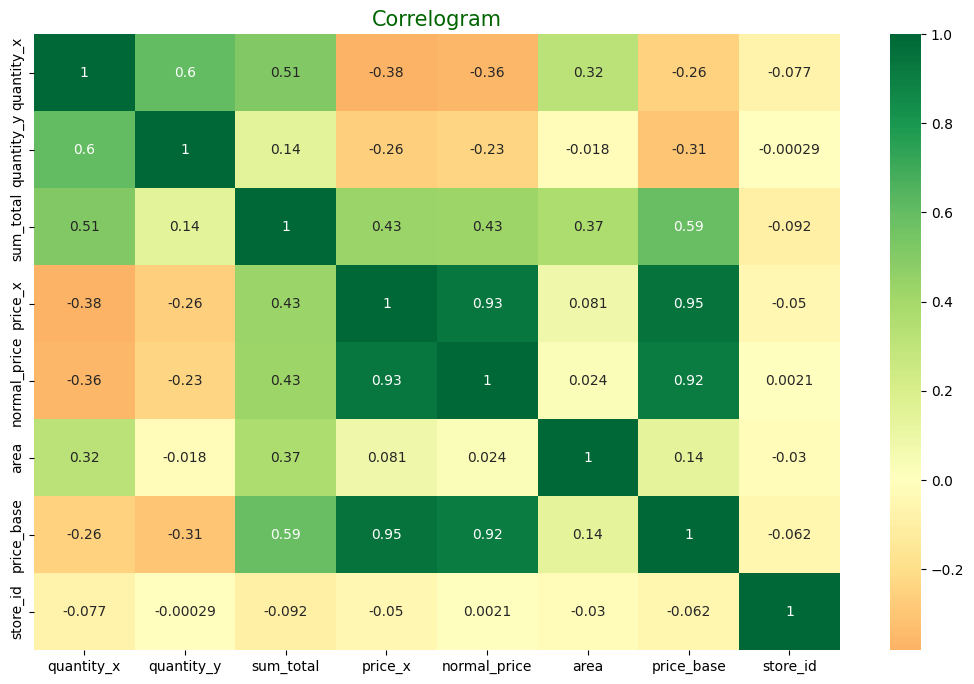

In [31]:
corr = train_set[list(corrs.index)].corr()

plt.figure(figsize = (13, 8))

sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)

plt.title('Correlogram', fontsize = 15, color = 'darkgreen')

plt.show()

In [32]:
# remove highly correlated coulumns
# train_set = train_set.drop(columns=["area"])

In [33]:
train_set.columns

Index(['date', 'item_id', 'quantity_x', 'price_base', 'sum_total', 'store_id',
       'normal_price', 'price_x', 'quantity_y', 'division', 'format', 'city',
       'area'],
      dtype='object')

In [34]:
train_set.dtypes.index.tolist()

['date',
 'item_id',
 'quantity_x',
 'price_base',
 'sum_total',
 'store_id',
 'normal_price',
 'price_x',
 'quantity_y',
 'division',
 'format',
 'city',
 'area']

In [35]:
categorical_column = train_set.select_dtypes(include='object').columns.tolist()
categorical_column

['item_id', 'division', 'format', 'city']

In [36]:
features_int = train_set.select_dtypes(include='float64').columns.tolist()
features_int

['quantity_x',
 'price_base',
 'sum_total',
 'normal_price',
 'price_x',
 'quantity_y']

In [37]:
features = ['date',
 'item_id',
 'quantity_x',
 'price_base',
 'sum_total',
 'store_id',
 'normal_price',
 'price_x',
 'quantity_y',
 'division',
 'format',
 'city',
 'area']

In [38]:
# features = ['date_sales', 'item_id', 'quantity_offline', 'price_base_offline',
#        'sum_total_offline', 'store_id', 'quantity_online', 'price_base_online',
#        'sum_total_online', 'date_matrix', 'dept_name', 'class_name',
#        'subclass_name', 'item_type', 'weight_volume', 'weight_netto',
#        'division', 'format', 'city']

In [39]:
# features_int = ['quantity_offline', 'price_base_offline', 'sum_total_offline',
#        'store_id', 'quantity_online', 'price_base_online', 'sum_total_online',
#        'weight_volume', 'weight_netto']
# features_int

In [40]:
train_num_agg = train_set.groupby("item_id")[features_int].agg(['first', 'mean', 'std', 'min', 'max', 'last'])

train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]

train_num_agg.reset_index(inplace = True)



# # Lag Features

for col in train_num_agg:

  if 'last' in col and col.replace('last', 'first') in train_num_agg:

    train_num_agg[col + '_lag_sub'] = train_num_agg[col] - train_num_agg[col.replace('last', 'first')]

    train_num_agg[col + '_lag_div'] = train_num_agg[col] / train_num_agg[col.replace('last', 'first')]

In [41]:
train_set = train_set.merge(train_num_agg, how = 'inner', on = 'item_id')

In [42]:
test_num_agg = test_set.groupby("item_id")[features_int].agg(['first', 'mean', 'std', 'min', 'max', 'last'])

test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]

test_num_agg.reset_index(inplace = True)


# Lag Features

for col in test_num_agg:

  if 'last' in col and col.replace('last', 'first') in test_num_agg:

    test_num_agg[col + '_lag_sub'] = test_num_agg[col] - test_num_agg[col.replace('last', 'first')]

    test_num_agg[col + '_lag_div'] = test_num_agg[col] / test_num_agg[col.replace('last', 'first')]

In [43]:
test_set = test_set.merge(test_num_agg, how = 'inner', on = 'item_id')

In [44]:
train_set['date'] = pd.to_datetime(train_set['date'])
test_set['date'] = pd.to_datetime(test_set['date'])

train_set['date'] = train_set['date'].astype('int64') 
test_set['date'] = test_set['date'].astype('int64') 

In [45]:
from sklearn.impute import SimpleImputer

categorical_columns = ['item_id', 'division', 'format', 'city']

for col in categorical_columns:
    train_set[col] = train_set[col].astype('category')
    test_set[col] = test_set[col].astype('category')

for col in categorical_columns:
        train_set[col] = train_set[col].astype(str)
        imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
        train_set[col] = imputer.fit_transform(train_set[[col]]).ravel()

for col in categorical_columns:
        test_set[col] = test_set[col].astype(str)
        imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
        test_set[col] = imputer.fit_transform(test_set[[col]]).ravel()

In [46]:
# train.dropna(axis=1, how='all', inplace=True)
# test.dropna(axis=1, how='all', inplace=True)

train_set.fillna(-1, inplace=True)
test_set.fillna(-1, inplace=True)

In [47]:
df_train = train_set.copy()
df_test = test_set.copy()

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:909: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


<Axes: xlabel='fold'>

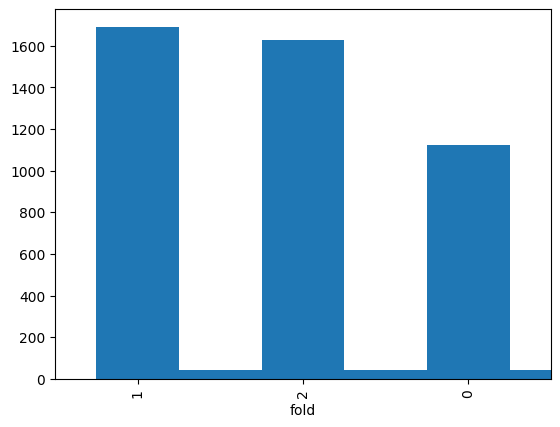

In [48]:
from sklearn.model_selection import StratifiedGroupKFold


# Sturge's rule
num_bins = int(np.floor(1+(3.3)*(np.log2(len(df_train)))))



df_train['bins'] = pd.cut(df_train['quantity_x'], bins=num_bins, labels=False)

df_train['bins'].hist()

df_train['fold'] = -1



groups = np.array(df_train['item_id'].values)

N_FOLDS = 3

strat_kfold = StratifiedGroupKFold(n_splits=N_FOLDS, random_state=42, shuffle=True)

for i, (_, train_index) in enumerate(strat_kfold.split(df_train.index, df_train['bins'], groups=groups)):

    df_train.iloc[train_index, -1] = i



df_train['fold'] = df_train['fold'].astype('int')



df_train.fold.value_counts().plot.bar()

In [49]:
# Convert object columns to category
for col in df_train.select_dtypes(include='object').columns:
    df_train[col] = df_train[col].astype('category')
    df_test[col] = df_test[col].astype('category')

from sklearn.impute import SimpleImputer

categorical_columns = ['item_id', 'date_matrix', 'dept_name', 
                       'class_name', 'subclass_name', 'item_type', 'division', 
                       'format', 'city']

for col in df_train.select_dtypes(include='object').columns:
        df_train[col] = df_train[col].astype(str)
        imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
        df_train[col] = imputer.fit_transform(df_train[[col]]).ravel()

for col in df_train.select_dtypes(include='object').columns:
        df_test[col] = df_test[col].astype(str)
        imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
        df_test[col] = imputer.fit_transform(df_test[[col]]).ravel()

In [50]:
import optuna
import xgboost as xgb

def objective_xgb(trial):

    """

    Optuna objective function. Returns

    the RMSE for an XGBoost model



    Assumes the training data are

    polars data frames

    """
    for col in df_train.select_dtypes(include='object').columns:
        df_train[col] = df_train[col].astype('category')
        df_test[col] = df_test[col].astype('category')

    for col in df_train.select_dtypes(include='object').columns:
        df_train[col] = df_train[col].astype(str)
        imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
        df_train[col] = imputer.fit_transform(df_train[[col]]).ravel()

    for col in df_train.select_dtypes(include='object').columns:
        df_test[col] = df_test[col].astype(str)
        imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
        df_test[col] = imputer.fit_transform(df_test[[col]]).ravel()



    fold  = 0

    train_data = df_train[df_train.fold != fold].reset_index(drop=True)

    valid_data = df_train[df_train.fold == fold].reset_index(drop=True)



    xtrain, ytrain = train_data[features], train_data.quantity_x

    xvalid, yvalid = valid_data[features], valid_data.quantity_x





    dmat_train = xgb.DMatrix(xtrain, label = ytrain, enable_categorical=True)

    dmat_valid = xgb.DMatrix(xvalid, label = yvalid, enable_categorical=True)



#     # Suggest hyperparameters for XGBoost


    params = {'objective': 'reg:squarederror',

              'eval_metric': 'rmse',

              'seed': 19970507,

              'eta': trial.suggest_float("eta", 1e-2, 0.25, log = True),

              'max_depth': trial.suggest_int("max_depth", 1, 7),

              'lambda': trial.suggest_float("lambda", 1e-8, 100.0, log = True),

              'alpha': trial.suggest_float("alpha", 1e-8, 100.0, log = True),

             }



#     # To evaluate training progress (set verbose_eval = True)

    watchlist = [(dmat_train, 'train'), (dmat_valid, 'eval')]



    # Train the XGBoost model

    xgb_model = xgb.train(params,

                          dtrain = dmat_train,

                          num_boost_round = trial.suggest_int("num_boost_round", 20, 3000),

                          evals = watchlist,

                          verbose_eval = False)



    xgb_preds_valid = xgb_model.predict(dmat_valid)



    # Return the RMSE

    return mean_squared_error(yvalid, xgb_preds_valid, squared=False)

# Set up and run the Optuna study

study_xgb = optuna.create_study(direction = 'minimize')

study_xgb.optimize(objective_xgb, n_trials = 20)

[I 2025-01-14 19:50:54,595] A new study created in memory with name: no-name-7cc6a040-9925-4d34-99a2-65b67f33538e
[I 2025-01-14 19:50:56,469] Trial 0 finished with value: 0.013839328272854343 and parameters: {'eta': 0.032344076258860176, 'max_depth': 2, 'lambda': 59.00250420198541, 'alpha': 0.002595954042731763, 'num_boost_round': 2057}. Best is trial 0 with value: 0.013839328272854343.
[I 2025-01-14 19:50:58,103] Trial 1 finished with value: 0.02958144449229536 and parameters: {'eta': 0.05142891135371903, 'max_depth': 5, 'lambda': 3.4177714386053014e-05, 'alpha': 0.09099811284815756, 'num_boost_round': 2107}. Best is trial 0 with value: 0.013839328272854343.
[I 2025-01-14 19:50:59,088] Trial 2 finished with value: 0.1296366810422532 and parameters: {'eta': 0.17005700479181662, 'max_depth': 6, 'lambda': 2.3534715031703524e-06, 'alpha': 0.00025007890157255255, 'num_boost_round': 1272}. Best is trial 0 with value: 0.013839328272854343.
[I 2025-01-14 19:51:00,225] Trial 3 finished with va

In [51]:
study_xgb.best_params

{'eta': 0.018000229479578612,
 'max_depth': 1,
 'lambda': 45.87148831686439,
 'alpha': 0.2800614920036966,
 'num_boost_round': 2664}

In [52]:
for fold in range(N_FOLDS):
    for col in df_train.select_dtypes(include='object').columns:
        df_train[col] = df_train[col].astype('category')
        df_test[col] = df_test[col].astype('category')

    for col in df_train.select_dtypes(include='object').columns:
        df_train[col] = df_train[col].astype(str)
        imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
        df_train[col] = imputer.fit_transform(df_train[[col]]).ravel()
    
    for col in df_train.select_dtypes(include='object').columns:
        df_test[col] = df_test[col].astype(str)
        imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
        df_test[col] = imputer.fit_transform(df_test[[col]]).ravel()
        
    print(f'Training on fold {fold}')
    train_data = df_train[df_train.fold != fold].reset_index(drop=True)
    valid_data = df_train[df_train.fold == fold].reset_index(drop=True)
    xtrain, ytrain = train_data[features], train_data.quantity_x
    xvalid, yvalid = valid_data[features], valid_data.quantity_x
    
    dtrain = xgb.DMatrix(xtrain, ytrain, enable_categorical=True)
    
    xgb_params = {'eta': 0.16321450870519139,
 'max_depth': 3,
 'lambda': 0.0019227716799503742,
 'alpha': 1.7154505215459198e-07,
 'num_boost_round': 1179}
    num_boost_rounds = 1843
    
    model = xgb.train(

      dict(xgb_params, silent=False),

      dtrain,

      num_boost_round=num_boost_rounds)
    
    dval = xgb.DMatrix(xvalid, yvalid , enable_categorical=True)


    vl_mse = mean_squared_error(yvalid, model.predict(dval), squared=False)

    print(f"fold {fold} rmse: ", vl_mse)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [19:51:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_boost_round", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Training on fold 0
fold 0 rmse:  0.013608494399015052
Training on fold 1


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [19:51:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_boost_round", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


fold 1 rmse:  0.03518218601003404
Training on fold 2


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [19:51:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_boost_round", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


fold 2 rmse:  0.014812590919602464


In [53]:
df_train[features].columns

Index(['date', 'item_id', 'quantity_x', 'price_base', 'sum_total', 'store_id',
       'normal_price', 'price_x', 'quantity_y', 'division', 'format', 'city',
       'area'],
      dtype='object')

In [54]:
df_test = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/test.csv", sep=";")

# df_test.rename(columns={'date': 'date_sales'}, inplace=True)

df_test.columns.tolist()

['row_id', 'item_id', 'store_id', 'date']

In [55]:
val = df_test['row_id'].shape
val

(883680,)

In [ ]:
sales_online_merged = pd.merge(df_test,sales, on=["store_id", "item_id"], how="left")
sales_online_merged = pd.merge(sales_online_merged, markdown, on=["date", "item_id", "store_id"])
sales_online_merged = pd.merge(sales_online_merged, price_history, on=["date", "item_id", "store_id"], how="left")
df_test = pd.merge(sales_online_merged, stores, on="store_id", how="left")

In [ ]:
# Final merge with stores to add store-specific information and add suffix for store columns
# sales_online_merged = pd.merge(df_test, sales, on=["item_id", "store_id"], how="right")

# # Merge sales and online data with suffixes to differentiate offline and online columns
# sales_online_merged = pd.merge(sales_online_merged, online, on=["date", "item_id", "store_id"], suffixes=('_offline', '_online'))

# # Merge with markdowns using 'left' join to keep all sales data
# sales_online_merged = pd.merge(sales_online_merged, markdown, on=["date", "item_id", "store_id"], how="left")

# # Merge with price_history using 'left' join to keep all previous data
# sales_online_merged = pd.merge(sales_online_merged, price_history, on=["date", "item_id", "store_id"], how="left")

# # Merge with discount_history using 'left' join to keep all previous data
# sales_online_merged = pd.merge(sales_online_merged, discount_history, on=["date", "item_id", "store_id"], how="left")

# # Merge with actual_matrix to add product availability data
# sales_online_merged = pd.merge(sales_online_merged, actual_matrix, on=["item_id", "store_id"], how="left", suffixes=('_sales', '_matrix'))

# # Merge with catalog to add product details
# sales_online_merged = pd.merge(sales_online_merged, catalog, on="item_id", how="left")

# # Final merge with stores to add store-specific information and add suffix for store columns
# data_test = pd.merge(sales_online_merged, stores, on="store_id", how="left", suffixes=('', '_store'))

In [ ]:
df_test.head()

In [ ]:
df_test.isnull().sum()

In [ ]:
for col in data_test.select_dtypes(include='object').columns:
    data_test[col] = data_test[col].astype('category')

for col in data_test.select_dtypes(include='object').columns:
        data_test[col] = data_test[col].astype(str)
        imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
        data_test[col] = imputer.fit_transform(data_test[[col]]).ravel()

In [ ]:
# Convert object columns to categorical explicitly
categorical_cols = data_test.select_dtypes(include='object').columns

# Check which columns are still 'object'
print("Before conversion to category:", categorical_cols)

# Convert object columns to 'category'
for col in categorical_cols:
    data_test[col] = data_test[col].astype('category')

In [ ]:
data_test.columns

In [ ]:
# from sklearn.impute import SimpleImputer

# # Impute categorical columns with 'Unknown'
# for col in data_test.select_dtypes(include='category').columns:
#     if data_test[col].notna().sum() > 0:  # Only impute if the column is not empty
#         imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
#         data_test[col] = imputer.fit_transform(data_test[[col]]).ravel()
#     else:
#         data_test[col] = 'Unknown'  # Directly set to 'Unknown' if the column is empty

# # Fill numerical columns with -1
# data_test.select_dtypes(include=['int', 'float']).fillna(-1, inplace=True)

In [ ]:
print(data_test.dtypes)

In [ ]:
data_test.columns

In [ ]:
# dtest = xgb.DMatrix(data_test[features].fillna(-1))
dtest = xgb.DMatrix(data_test[features], enable_categorical=True)

pred = model.predict(dtest)
pred

In [ ]:
val

In [ ]:
pred.shape

In [ ]:
submission = pd.DataFrame({
    'row_id': val,
    'quantity':pred.round().astype(int) 
})

submission.to_csv('submission.csv', index=False)

In [ ]:
sub = pd.read_csv('submission.csv')
sub.head